# **Diversity report**

## **Completeness analysis**

Author: Daning Montaño - Ocampo

# **1. Packages and libraries**

In [419]:
library(dplyr)
library(ggplot2)
library(sf)
library(iNEXT)
library(tidyr)
library(vegan)
library(tibble)
library(ggspatial)
library(patchwork)

#library(doParallel)
#

# 2. Load clean data and grids

## 2.1. Records

In [375]:
species_records = read.csv("../Data/Records/species_records_clean.csv")

# Transform to sf object
species_records_sf = st_as_sf(species_records, coords = c("decimalLongitude", "decimalLatitude"), crs = 4326)
species_records_sf

Simple feature collection with 26187 features and 16 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -78.46784 ymin: -2.068253 xmax: -75.5828 ymax: 1.5
Geodetic CRS:  WGS 84
First 10 features:
   id_record database_name database_id occurrenceID basisOfRecord verbatimEventDate   recordedBy year institutionCode taxonRank         class       order
1          1        BIOWEB   BIOWEB_45    QCA129294          <NA>    14/6/1992 0:00  J.S. Miller   NA            <NA>   species Magnoliopsida Magnoliales
2          2        BIOWEB   BIOWEB_46    QCA129427          <NA>    24/4/1981 0:00   E.W. Davis   NA            <NA>   species Magnoliopsida Magnoliales
3          3        BIOWEB   BIOWEB_49    QCA129514          <NA>    21/4/1981 0:00   E.W. Davis   NA            <NA>   species Magnoliopsida Magnoliales
4          5        BIOWEB   BIOWEB_51    QCA129793          <NA>    24/4/1981 0:00   E.W. Davis   NA            <NA>   species Magnoliopsida Magnoliales
5          8      

## 2.2. Arajuno polygon

In [376]:
arajuno_poly = st_read("../Data/SHP/Arajuno.shp")



Reading layer `Arajuno' from data source `C:\PACHAMAMA\CONSERVACION\BIODIVERSIDAD ARAJUNO\ArajunoBiodiversity\Data\SHP\Arajuno.shp' using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 6 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -77.8054 ymin: -1.703907 xmax: -75.58041 ymax: -1.003981
Geodetic CRS:  WGS 84


## 2.3. Hexagons 10 km

In [377]:
grid_10km = st_read("../Data/SHP/HEXAGON_10_KM.shp")
grid_10km$id_10km = grid_10km$id
grid_10km = grid_10km %>% select(-id)

Reading layer `HEXAGON_10_KM' from data source `C:\PACHAMAMA\CONSERVACION\BIODIVERSIDAD ARAJUNO\ArajunoBiodiversity\Data\SHP\HEXAGON_10_KM.shp' using driver `ESRI Shapefile'
Simple feature collection with 928 features and 5 fields
Geometry type: POLYGON
Dimension:     XY
Bounding box:  xmin: -77.80573 ymin: -1.749935 xmax: -75.54047 ymax: -1.001861
Geodetic CRS:  WGS 84


Cut Hexagons using Arajuno poly

In [378]:
grid_10km_cut = st_intersection(grid_10km, arajuno_poly)

Warning message:
attribute variables are assumed to be spatially constant throughout all geometries 


# 3. Join points to grids

In [379]:
recors_grid_10km <- st_join(
  species_records_sf,
  grid_10km_cut,
  join = st_within                              # inside polygons
)

# 4. Records and Sp per 10 km grid

## 4.1. All Taxas

We calculate the number of records per 10 km grid usind id_10km

In [380]:
total_grid = recors_grid_10km %>%
  as.data.frame() %>%
  group_by(id_10km)%>%
  summarise(Total_records = n()) %>%
  as.data.frame()

sp_grid = recors_grid_10km %>%
  as.data.frame() %>%
  group_by(id_10km)%>%
  distinct(scientificName) %>%
  summarise(Total_sp = n()) %>%
  as.data.frame()%>%
  mutate(Group = "All")

total_records_grid = total_grid %>% left_join(sp_grid, "id_10km")


## 4.2. Records per taxa

Create new categories

In [381]:
recors_grid_10km <- recors_grid_10km %>% 
  mutate(group = case_when(
    # Plants (vascular + non-vascular)
    class %in% c("Magnoliopsida", "Liliopsida",
                 "Lycopodiopsida", "Polypodiopsida",
                 "Bryopsida", "Jungermanniopsida",
                 "Gnetopsida", "Cycadopsida") ~ "Plants",

    # Birds
    class == "Aves" ~ "Birds",

    # Mammals
    class == "Mammalia" ~ "Mammals",

    # Arthropods + other invertebrates similar
    class %in% c("Insecta", "Arachnida", "Chilopoda",
                 "Malacostraca", "Gastropoda", "Bivalvia",
                 "Ostracoda") ~ "Arthropods",

    # Amphibians
    class == "Amphibia" ~ "Amphibians",

    # Reptiles
    class == "Reptilia" ~ "Reptiles",

    # Fungi
    class %in% c("Agaricomycetes", "Pezizomycetes",
                 "Sordariomycetes", "Tremellomycetes") ~ "Fungi",

    # Fish classes (separados si es necesario)
    class %in% c("Actinopterygii", "Elasmobranchii") ~ "Fish",

    # Everything else
    TRUE ~ "Others"
  ))
  records_x_taxa = recors_grid_10km %>%
    as.data.frame()%>%
    group_by(group)%>%
    summarise(Records = n())%>%
    arrange(-Records)
  
  records_x_taxa

# A tibble: 9 × 2
  group      Records
  <chr>        <int>
1 Plants       11593
2 Birds         8442
3 Mammals       2156
4 Amphibians    2080
5 Reptiles      1124
6 Arthropods     577
7 Fish           174
8 Fungi           32
9 Others           9

Records and species per taxa

In [382]:
taxas = unique(recors_grid_10km$group)


results_taxa_per_grid = data.frame(
  id_10km = numeric(0),
  Total_records = numeric(0),
  Total_sp = numeric(0)
)


for (i in taxas) {

  ## taxa print
  cat("Procces records and species", i, "\n")

  ## filter
  taxa_records = recors_grid_10km %>%
    filter(group == i) %>%
    group_by(id_10km) %>%
    summarise(Total_records = n()) %>%
    as.data.frame() %>%
    select(id_10km, Total_records)

  taxa_sp = recors_grid_10km %>%
    filter(group == i) %>%
    group_by(id_10km) %>%
    distinct(scientificName) %>%
    summarise(Total_sp = n()) %>%
    as.data.frame() %>%
    select(id_10km, Total_sp) %>%
    mutate(Group = i)

  results_taxa = taxa_records %>% 
    left_join(taxa_sp, "id_10km") %>% 
    as.data.frame()
  
  results_taxa_per_grid = rbind(results_taxa_per_grid, results_taxa)

  cat("- - - - - - - - - - - - - - - - - - - - -\n")

}

Procces records and species Plants 
- - - - - - - - - - - - - - - - - - - - -
Procces records and species Amphibians 
- - - - - - - - - - - - - - - - - - - - -
Procces records and species Arthropods 
- - - - - - - - - - - - - - - - - - - - -
Procces records and species Mammals 
- - - - - - - - - - - - - - - - - - - - -
Procces records and species Birds 
- - - - - - - - - - - - - - - - - - - - -
Procces records and species Reptiles 
- - - - - - - - - - - - - - - - - - - - -
Procces records and species Others 
- - - - - - - - - - - - - - - - - - - - -
Procces records and species Fish 
- - - - - - - - - - - - - - - - - - - - -
Procces records and species Fungi 
- - - - - - - - - - - - - - - - - - - - -


## 4.3. Join data per grid

In [383]:

results_taxa_total= rbind( results_taxa_total, total_records_grid)


Example Map

In [ ]:
grid_10km_cut$

Simple feature collection with 498 features and 11 fields
Geometry type: GEOMETRY
Dimension:     XY
Bounding box:  xmin: -77.80148 ymin: -1.703907 xmax: -75.58041 ymax: -1.004941
Geodetic CRS:  WGS 84
First 10 features:
       left     top    right  bottom id_10km DPA_VALOR DPA_ANIO DPA_CANTON DPA_DESCAN DPA_PROVIN DPA_DESPRO                       geometry
6  855570.7 9863766 861344.2 9858766       6         0     2012       1604    ARAJUNO         16    PASTAZA POLYGON ((-77.78936 -1.2757...
7  855570.7 9858766 861344.2 9853766       7         0     2012       1604    ARAJUNO         16    PASTAZA POLYGON ((-77.80148 -1.3052...
8  855570.7 9853766 861344.2 9848766       8         0     2012       1604    ARAJUNO         16    PASTAZA POLYGON ((-77.75364 -1.3436...
20 859900.8 9871266 865674.3 9866266      20         0     2012       1604    ARAJUNO         16    PASTAZA POLYGON ((-77.74971 -1.2079...
21 859900.8 9866266 865674.3 9861266      21         0     2012       1604    ARAJUNO

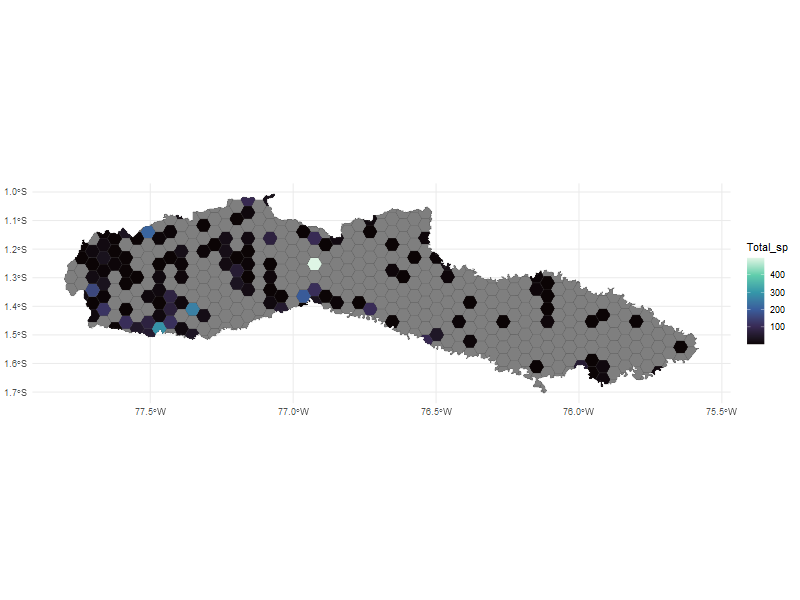

In [385]:

taxa_filter_records_per_grid = results_taxa_total%>% 
  filter(Group == "Plants")


grid_10km_cut%>% 
left_join(taxa_filter_records_per_grid, by = "id_10km")%>% 
  ggplot() +
    geom_sf(aes(fill = Total_sp), color = "grey30", size = 0.1) +
    scale_fill_viridis_c(option = "mako") +
    theme_minimal()

# 5. Sampling Completness

Calculate completnes for all Arajuno using incidens data and each 10 km cell is a unit. We conduce the analysis per taxa

Use iNEXT funtion to calculate the sampling coverage in Arajuno, an only extract richness (q=0) and sampling coverage

Create a funtion to apply iNext funtion per Taxa in all Arajuno

In [338]:
run_iNEXT_incidence_taxon <- function(
  taxon_name,
  min_records = 10,
  nboot = 100,
  save_path = NULL
) {

  #----------------------------------------------------------
  # 1. Filtrar celdas válidas
  #----------------------------------------------------------
  id_units <- results_taxa_total %>%
    filter(Group == taxon_name,
           Total_records >= min_records,
           !is.na(id_10km)) %>%
    pull(id_10km) %>%
    unique()

  if (length(id_units) == 0)
    stop("No hay celdas que cumplan el filtro")

  cat("Celdas filtradas:", length(id_units), "\n")

  #----------------------------------------------------------
  # 2. Filtrar registros del taxón en esas celdas
  #----------------------------------------------------------
  df_taxon <- recors_grid_10km %>%
    filter(group == taxon_name,
           id_10km %in% id_units)

  if (nrow(df_taxon) == 0)
    stop("No hay registros del taxón en estas celdas")

  cat("Registros encontrados:", nrow(df_taxon), "\n")

  #----------------------------------------------------------
  # 3. Crear matriz de incidencia (especies x celdas)
  #----------------------------------------------------------
  incid_wide <- df_taxon %>%
    distinct(id_10km, scientificName) %>%
    mutate(val = 1L) %>%
    pivot_wider(
      id_cols    = id_10km,
      names_from = scientificName,
      values_from = val,
      values_fill = 0
    )

  ids <- incid_wide$id_10km

  incid_mat <- incid_wide %>%
    select(-id_10km) %>%
    as.data.frame()

  mat_final <- as.data.frame(t(incid_mat))

  cat("Especies:", nrow(mat_final),
      "| Celdas:", ncol(mat_final), "\n")

  #----------------------------------------------------------
  # 4. Ejecutar iNEXT
  #----------------------------------------------------------
  result_inext <- iNEXT::iNEXT(
    list(assemblage = mat_final),
    q = 0,
    datatype = "incidence_raw",
    se = TRUE,
    conf = 0.95,
    nboot = nboot
  )

  if (!is.null(save_path)) {
    saveRDS(result_inext, save_path)
  }

  #----------------------------------------------------------
  # 5. EXTRAER LAS MÉTRICAS (observadas y extrapoladas)
  #----------------------------------------------------------

  # Sample coverage
  sc <- result_inext$DataInfo$SC

  # Observado
  sp_obs <- result_inext$iNextEst$size_based %>%
    filter(Method == "Observed") %>%
    pull(qD)

  # Última extrapolación
  sp_ext <- result_inext$iNextEst$size_based %>%
    filter(Method == "Extrapolation") %>%
    slice(n()) %>%
    pull(qD)

  # Unidades observadas
  units_obs <- result_inext$iNextEst$size_based %>%
    filter(Method == "Observed") %>%
    pull(t)

  # Unidades extrapoladas (último valor)
  units_ext <- result_inext$iNextEst$size_based %>%
    filter(Method == "Extrapolation") %>%
    slice(n()) %>%
    pull(t)

  metrics <- data.frame(
    sample_coverage_observed = sc,
    species_observed = sp_obs,
    species_extrapolated = sp_ext,
    units_observed = units_obs,
    units_extrapolated = units_ext
  )

  cat("Sample coverage:", sc,
      ", Sp observed:", sp_obs,
      ", Units observed:", units_obs,
      ", Units extrapolated:", units_ext,
      ", Sp extrapolated:", sp_ext, "\n")

  #----------------------------------------------------------
  # 6. Retorno final
  #----------------------------------------------------------
  return(list(
    result = result_inext,
    metrics = metrics
  ))
}


Create a funtion to apply iNext funtion per Taxa and per Hexagon

In [411]:
run_SC_abundance_taxon <- function(
  taxon_name,
  min_records = 10,
  nboot = 100
) {

  #----------------------------------------------------------
  # 0. Cargar datasets internos de tu entorno global
  #----------------------------------------------------------
  recors_grid_10km  <- recors_grid_10km
  results_taxa_total <- results_taxa_total
  grid_10km_cut     <- grid_10km_cut

  #----------------------------------------------------------
  # 1. Filtrar celdas válidas según taxón
  #----------------------------------------------------------
  id_units <- results_taxa_total %>%
    filter(Group == taxon_name,
           Total_records >= min_records,
           !is.na(id_10km)) %>%
    pull(id_10km) %>%
    unique()

  if (length(id_units) == 0)
    stop("No hay celdas que cumplan el filtro")

  cat("Celdas filtradas:", length(id_units), "\n")

  #----------------------------------------------------------
  # 2. Filtrar SOLO registros del taxón en esas celdas
  #----------------------------------------------------------
  df_taxon <- recors_grid_10km %>%
    filter(group == taxon_name,
           id_10km %in% id_units)

  if (nrow(df_taxon) == 0)
    stop("No hay registros del taxón en estas celdas")

  cat("Registros encontrados:", nrow(df_taxon), "\n")

  #----------------------------------------------------------
  # 3. Contenedor resultados SC
  #----------------------------------------------------------
  results_sc <- data.frame(
    id_10km           = integer(),
    Sampling_coverage = numeric()
  )

  pb <- txtProgressBar(min = 0, max = length(id_units), style = 3)
  count <- 0

  #----------------------------------------------------------
  # 4. Loop celda por celda
  #----------------------------------------------------------
  for (i in id_units) {

    df_i <- df_taxon %>% filter(id_10km == i)

    if (nrow(df_i) < min_records) {
      results_sc <- rbind(
        results_sc,
        data.frame(id_10km = i, Sampling_coverage = NA_real_)
      )
      count <- count + 1
      setTxtProgressBar(pb, count)
      next
    }

    #----------------------------------------------------------
    # 5. Abundancia por especie (scientificName o genus)
    #----------------------------------------------------------
    abund_df <- df_i %>%
      group_by(genus) %>%
      summarise(n = n(), .groups = "drop")

    if (nrow(abund_df) == 0) {
      results_sc <- rbind(
        results_sc,
        data.frame(id_10km = i, Sampling_coverage = NA_real_)
      )
      count <- count + 1
      setTxtProgressBar(pb, count)
      next
    }

    abund_vec <- abund_df$n
    names(abund_vec) <- abund_df$genus

    #----------------------------------------------------------
    # 6. iNEXT – solo SC observado, sin q, sin se
    #----------------------------------------------------------
    sc_obs <- tryCatch({
      r_inext <- iNEXT(
        list(assemblage = abund_vec),
        datatype = "abundance",
        se       = FALSE,
        nboot    = nboot
      )
      as.numeric(r_inext$DataInfo$SC)
    }, error = function(e) NA_real_)

    # guardar
    results_sc <- rbind(
      results_sc,
      data.frame(id_10km = i, Sampling_coverage = sc_obs)
    )

    count <- count + 1
    setTxtProgressBar(pb, count)
  }

  close(pb)

  #----------------------------------------------------------
  # 7. Unir SC con hexágonos y devolver
  #----------------------------------------------------------
  hex_out <- grid_10km_cut %>%
    left_join(results_sc, by = "id_10km")

  return(hex_out)
}


Spatial metrics

In [479]:

compute_hex_metrics <- function(
  hex_sf,
  records_col   = "Total_records",
  richness_col  = "Total_sp",
  coverage_col  = "Sampling_coverage",
  majority_prop = 0.8   # “mayoría de los registros” = 80%
) {

  if (!inherits(hex_sf, "sf")) {
    stop("hex_sf debe ser un objeto sf.")
  }

  # Área en m2 y ha (asume CRS proyectado en metros)
  area_m2 <- sf::st_area(hex_sf)
  area_ha <- as.numeric(area_m2) / 10000
  area_total_ha <- sum(area_ha, na.rm = TRUE)

  # Extraer columnas
  recs <- hex_sf[[records_col]]
  rich <- hex_sf[[richness_col]]
  covg <- hex_sf[[coverage_col]]

  # Limpiar NA
  recs[is.na(recs)] <- 0
  rich[is.na(rich)] <- NA
  covg[is.na(covg)] <- NA

  ## 1) Registros: área con ≥1 registro y sin registros
  idx_rec <- recs > 0
  area_rec_ha   <- sum(area_ha[idx_rec], na.rm = TRUE)
  pct_area_rec  <- 100 * area_rec_ha / area_total_ha
  pct_area_nrec <- 100 - pct_area_rec

  ## 2) “Mayoría” de registros: en cuántos hexágonos se acumula majority_prop
  total_recs <- sum(recs, na.rm = TRUE)

  n_hex_majority   <- NA_integer_
  area_majority_ha <- NA_real_
  pct_area_majority <- NA_real_

  if (total_recs > 0) {
    ord          <- order(recs, decreasing = TRUE)
    recs_sorted  <- recs[ord]
    area_sorted  <- area_ha[ord]
    cumsum_recs  <- cumsum(recs_sorted)
    threshold    <- majority_prop * total_recs
    idx_major    <- which(cumsum_recs >= threshold)[1]

    n_hex_majority   <- idx_major
    area_majority_ha <- sum(area_sorted[seq_len(idx_major)], na.rm = TRUE)
    pct_area_majority <- 100 * area_majority_ha / area_total_ha
  }

  ## 3) Especies: media y mediana por celda
  mean_rich   <- mean(rich, na.rm = TRUE)
  median_rich <- stats::median(rich, na.rm = TRUE)

  ## 4) Especies: celdas outlier en riqueza (regla IQR)
  outlier_n_cells  <- NA_integer_
  outlier_area_pct <- NA_real_

  rich_clean <- rich[!is.na(rich)]
  if (length(rich_clean) > 0) {
    stats_r   <- boxplot.stats(rich_clean)
    out_vals  <- stats_r$out
    idx_out   <- rich %in% out_vals & !is.na(rich)
    outlier_n_cells <- sum(idx_out, na.rm = TRUE)
    outlier_area_ha <- sum(area_ha[idx_out], na.rm = TRUE)
    outlier_area_pct <- 100 * outlier_area_ha / area_total_ha
  }

  ## 5) Correlación registros–especies
  idx_cor <- !is.na(rich) & !is.na(recs)
  cor_rec_sp <- NA_real_
  if (sum(idx_cor) > 2 &&
      stats::sd(recs[idx_cor]) > 0 &&
      stats::sd(rich[idx_cor]) > 0) {
    cor_rec_sp <- stats::cor(recs[idx_cor], rich[idx_cor], method = "pearson")
  }

  ## 6) Completitud: área con SC ≥ 0.5 y ≥ 0.9
  idx_cov50 <- !is.na(covg) & covg >= 0.5
  idx_cov90 <- !is.na(covg) & covg >= 0.9

  area_cov50_ha <- sum(area_ha[idx_cov50], na.rm = TRUE)
  area_cov90_ha <- sum(area_ha[idx_cov90], na.rm = TRUE)

  pct_area_cov50 <- 100 * area_cov50_ha / area_total_ha
  pct_area_cov90 <- 100 * area_cov90_ha / area_total_ha

  ## 7) Métrica extra: Gini de registros (sesgo espacial del esfuerzo)
  gini_records <- NA_real_
  recs_pos <- recs[recs > 0]
  if (length(recs_pos) > 1) {
    recs_sorted2 <- sort(recs_pos)
    n <- length(recs_sorted2)
    gini_records <- (2 * sum(recs_sorted2 * seq_len(n)) / (n * sum(recs_sorted2))) -
      (n + 1) / n
  }

  ## Dataframe de salida
  metrics <- data.frame(
    metric_name = c(
      "total_area_ha",
      "area_with_records_pct",
      "area_with_records_ha",
      "area_without_records_pct",
      "hexes_majority_records_count",
      "hexes_majority_records_area_pct",
      "mean_species_per_hex",
      "median_species_per_hex",
      "outlier_hexes_species_count",
      "outlier_hexes_species_area_pct",
      "records_species_correlation_pearson",
      "area_coverage_ge_0.5_pct",
      "area_coverage_ge_0.9_pct",
      "records_gini_coefficient"
    ),
    metric_description_en = c(
      "Total area of the study region in hectares.",
      "Percentage of total area where at least one record is present.",
      "Total area (ha) where at least one record is present.",
      "Percentage of total area with zero records.",
      "Number of hexagons that hold the majority of records (cumulative proportion defined by majority_prop).",
      "Percentage of total area occupied by hexagons that hold the majority of records.",
      "Mean number of species per hexagon.",
      "Median number of species per hexagon.",
      "Number of hexagons considered outliers in species richness (based on the IQR rule).",
      "Percentage of total area covered by hexagons that are outliers in species richness.",
      "Pearson correlation between number of records and number of species per hexagon.",
      "Percentage of total area with sampling coverage ≥ 0.5.",
      "Percentage of total area with sampling coverage ≥ 0.9.",
      "Gini coefficient of the spatial distribution of records across hexagons (0 = even, 1 = highly concentrated)."
    ),
    metric_value = c(
      area_total_ha,
      pct_area_rec,
      area_rec_ha,
      pct_area_nrec,
      n_hex_majority,
      pct_area_majority,
      mean_rich,
      median_rich,
      outlier_n_cells,
      outlier_area_pct,
      cor_rec_sp,
      pct_area_cov50,
      pct_area_cov90,
      gini_records
    ),
    stringsAsFactors = FALSE
  )

  return(metrics)
}


Plots and maps

In [486]:
make_inext_plot <- function(res_obj, type, title, ylab) {
  ggiNEXT(res_obj, type = type) +
    scale_color_manual(values = color_hoja) +
    scale_fill_manual(values = adjustcolor(color_hoja, alpha.f = 0.35)) +
    labs(
      title = title,
      x     = "Unidades de muestreo",
      y     = ylab
    ) +
    custom_theme_fp
}


make_hex_map <- function(data_sf, fill_var, fill_name, title) {
  ggplot(data_sf) +
    geom_sf(aes(fill = !!sym(fill_var)), color = "grey30", linewidth = 0.10) +
    scale_fill_gradient(
      name = fill_name,
      low  = color_hoja_light,
      high = color_hoja
    ) +
    labs(title = title) +
    custom_theme_fp_map +
    annotation_scale(location = "bl", width_hint = 0.25) +
    annotation_north_arrow(
      location   = "tl",
      which_north = "true",
      style      = north_arrow_fancy_orienteering(
        fill     = color_hoja,
        line_col = color_hoja
      ),
      height = unit(1.2, "cm"),
      width  = unit(1.2, "cm")
    )
}


Custom Theme

In [451]:

color_hoja <- "#183D1E"   # Verde oscuro oficial Fundación Pachamama
color_hoja_light <- "#A9DFBF"  # Verde claro neutro complementario (no oficial pero compatible)

custom_theme_fp <- theme_minimal(base_size = 21) +
  theme(
    plot.title = element_text(size = 23, color = color_hoja),
    axis.title = element_text(size = 20, color = "black"),
    axis.text = element_text(size = 19, color = "black"),
    panel.grid.major = element_line(color = "#D6D8D9", linewidth = 0.3),
    panel.grid.minor = element_blank(),
    legend.position = "bottom",
    legend.title = element_blank(),
    legend.text = element_text(size = 19),
    plot.background = element_rect(fill = "white", color = NA),
    panel.background = element_rect(fill = "white", color = NA)
  )

  custom_theme_fp_map <- theme_minimal(base_size = 20) +
    theme(
      plot.title = element_text(size = 23, color = color_hoja),
      axis.title = element_text(size = 20),
      axis.text = element_text(size = 18),
      panel.grid = element_blank(),
      legend.position = "right",
      legend.title = element_text(size = 20, color = color_hoja),
      legend.text = element_text(size = 18)
    )
  


## 5.1. Birds

### Using All area

In [447]:
res_birds <- run_iNEXT_incidence_taxon(
  taxon_name = "Birds",
  min_records = 10,
  nboot = 100
)


Celdas filtradas: 54 
Registros encontrados: 7253 
Especies: 483 | Celdas: 54 
Sample coverage: 0.9514 , Sp observed: 483 , Units observed: 54 , Units extrapolated: 108 , Sp extrapolated: 564.116 


### Analysis per hexagon

In [448]:
hex_birds <- run_SC_abundance_taxon(
  taxon_name = "Birds",
  min_records = 10,
  nboot = 200
)



Celdas filtradas: 54 
Registros encontrados: 7253 
  |=============================================================================================================================================================| 100%


Warning message:
In EstiBootComm.Ind(x[[i]]) :
  This site has only one species. Estimation is not robust.


### Birds Report

Export plots

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


Warning message:
In ggiNEXT.iNEXT(res_obj, type = type) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


Warning message:
In ggiNEXT.iNEXT(res_obj, type = type) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


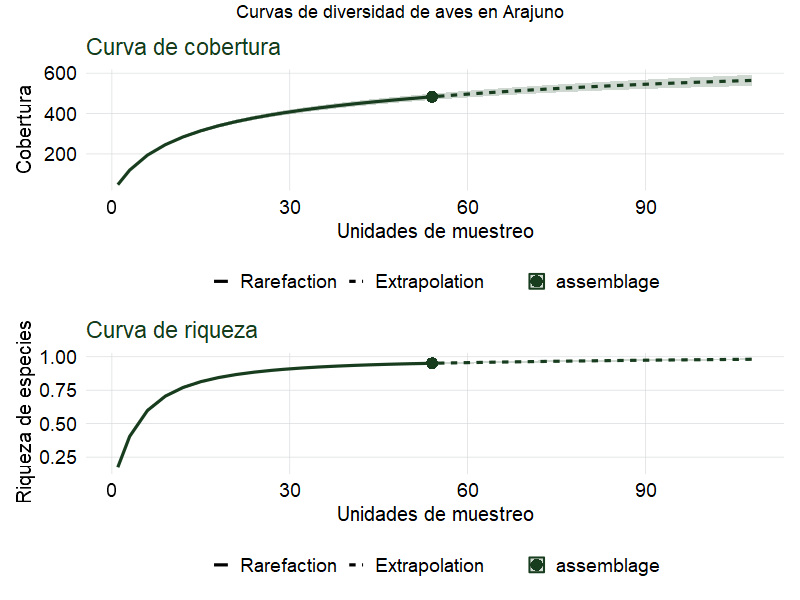

In [491]:
# Curva de cobertura
plot_units_coverage_birds <- make_inext_plot(
  res_obj = res_birds$result,
  type    = 1,
  title   = "Curva de cobertura",
  ylab    = "Cobertura"
)

# Curva de riqueza
plot_units_sp_birds <- make_inext_plot(
  res_obj = res_birds$result,
  type    = 2,
  title   = "Curva de riqueza",
  ylab    = "Riqueza de especies"
)
# Curvas pequeñas (derecha)
curves_birds <- plot_units_coverage_birds /
             plot_units_sp_birds
curves_birds = curves_birds+
  plot_annotation(
    title = "Curvas de diversidad de aves en Arajuno",
    theme = theme(
      plot.title = element_text(
        hjust = 0.5,        # << CENTRADO
        size = 18,
        face = "plain"
      )
    )
  )
  curves_birds


In [492]:
ggsave(
  filename = "../Results/Reports/Birds/aves_curves.png",
  plot     = curves_birds,
  width    = 9,
  height   = 9,
  dpi      = 300
)

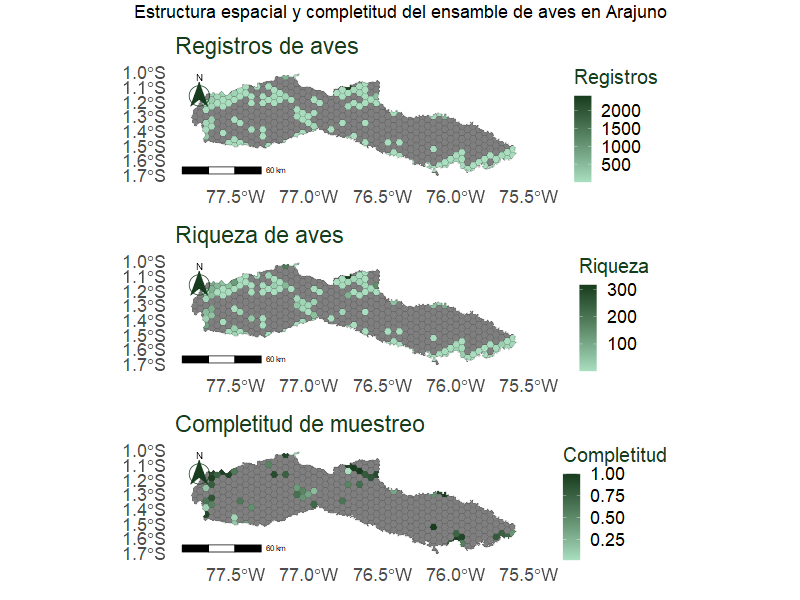

In [493]:
#-----------------------------------------
# Datos base para mapas (registros y spp)
#-----------------------------------------
taxa_filter_records_per_grid <- results_taxa_total %>%
  filter(Group == "Birds")

birds_grid <- grid_10km_cut %>%
  left_join(taxa_filter_records_per_grid, by = "id_10km")


# Mapa: registros
map_birds_records <- make_hex_map(
  data_sf   = birds_grid,
  fill_var  = "Total_records",
  fill_name = "Registros",
  title     = "Registros de aves"
)

# Mapa: riqueza
map_birds_sp <- make_hex_map(
  data_sf   = birds_grid,
  fill_var  = "Total_sp",
  fill_name = "Riqueza",
  title     = "Riqueza de aves"
)

# Mapa: completitud (usa hex_birds directamente)
map_birds_sc <- make_hex_map(
  data_sf   = hex_birds,
  fill_var  = "Sampling_coverage",
  fill_name = "Completitud",
  title     = "Completitud de muestreo"
)

maps_grid_birds <- (map_birds_records /
  map_birds_sp /
  map_birds_sc) +
plot_annotation(
title = "Estructura espacial y completitud del ensamble de aves en Arajuno",
theme = theme(
plot.title = element_text(
hjust = 0.5,
size  = 18,
face  = "plain"
)
)
)

maps_grid_birds

In [494]:
ggsave(
  filename = "../Results/Reports/Birds/mapas_aves.png",
  plot     = maps_grid_birds,
  width    = 14,
  height   = 18,
  dpi      = 300
)

Export spatial analysis

In [483]:
hex_birds_full <- grid_10km_cut %>% 
  left_join(taxa_filter_records_per_grid, by = "id_10km") %>%
  left_join(
    hex_birds %>% st_drop_geometry() %>% select(id_10km, Sampling_coverage),
    by = "id_10km"
  )
  metrics_birds <- compute_hex_metrics(
    hex_sf       = hex_birds_full,
    records_col  = "Total_records",
    richness_col = "Total_sp",
    coverage_col = "Sampling_coverage",
    majority_prop = 0.8   # mayoría = 80% de los registros
  )
  
write.csv(metrics_birds, "../Results/Reports/Birds/aves_spatial_metrics.csv")

Export metrics

In [473]:
write.csv(res_birds$metrics, "../Results/Reports/Birds/aves_metrics.csv")

Export shapes

In [ ]:
hex_birds_full <- grid_10km_cut %>% 
  left_join(taxa_filter_records_per_grid, by = "id_10km") %>%
  left_join(
    hex_birds %>% st_drop_geometry() %>% select(id_10km, Sampling_coverage),
    by = "id_10km"
  )

  st_write(
    hex_birds_full,
    "../Results/Reports/Birds/aves_shp/Aves_hexagonos_metricas.shp",
    delete_layer = TRUE
  )
  

Writing layer `Aves_hexagonos_metricas' to data source `../Results/Reports/Birds/shp/Aves_hexagonos_metricas.shp' using driver `ESRI Shapefile'
Writing 498 features with 15 fields and geometry type Unknown (any).


Warning message:
In abbreviate_shapefile_names(obj) :
  Field names abbreviated for ESRI Shapefile driver


## 5.2. Plants

### Using All area

In [474]:
res_plants <- run_iNEXT_incidence_taxon(
  taxon_name = "Plants",
  min_records = 10,
  nboot = 100
)


Celdas filtradas: 56 
Registros encontrados: 9513 
Especies: 1808 | Celdas: 56 
Sample coverage: 0.7086 , Sp observed: 1808 , Units observed: 56 , Units extrapolated: 112 , Sp extrapolated: 2564.331 


### Analysis per hexagon

In [476]:
hex_plants <- run_SC_abundance_taxon(
  taxon_name = "Plants",
  min_records = 10,
  nboot = 200
)


Celdas filtradas: 56 
Registros encontrados: 9513 
  |=============================================================================================================================================================| 100%


### Plants Report

Export plots

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


Warning message:
In ggiNEXT.iNEXT(res_obj, type = type) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.


Warning message:
In ggiNEXT.iNEXT(res_obj, type = type) :
  invalid color.var setting, the iNEXT object do not consist multiple assemblages, change setting as Order.q


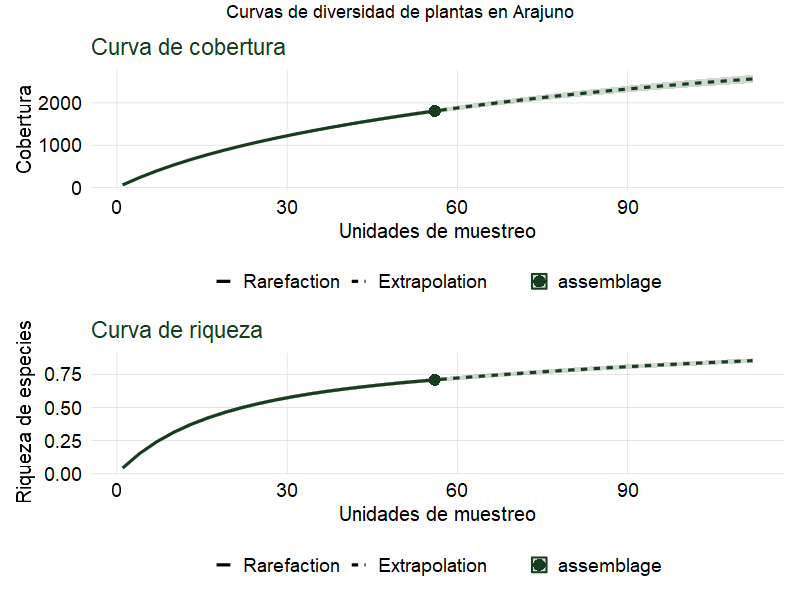

In [498]:
# Curva de cobertura
plot_units_coverage_plants<- make_inext_plot(
  res_obj = res_plants$result,
  type    = 1,
  title   = "Curva de cobertura",
  ylab    = "Cobertura"
)

# Curva de riqueza
plot_units_sp_plants <- make_inext_plot(
  res_obj = res_plants$result,
  type    = 2,
  title   = "Curva de riqueza",
  ylab    = "Riqueza de especies"
)
# Curvas pequeñas (derecha)
curves_plants <- plot_units_coverage_plants /
  plot_units_sp_plants
curves_plants = curves_plants+
  plot_annotation(
    title = "Curvas de diversidad de plantas en Arajuno",
    theme = theme(
      plot.title = element_text(
        hjust = 0.5,        # << CENTRADO
        size = 18,
        face = "plain"
      )
    )
  )
  curves_plants

In [499]:
ggsave(
  filename = "../Results/Reports/Plants/plantas_curves.png",
  plot     = curves_plants,
  width    = 9,
  height   = 9,
  dpi      = 300
)

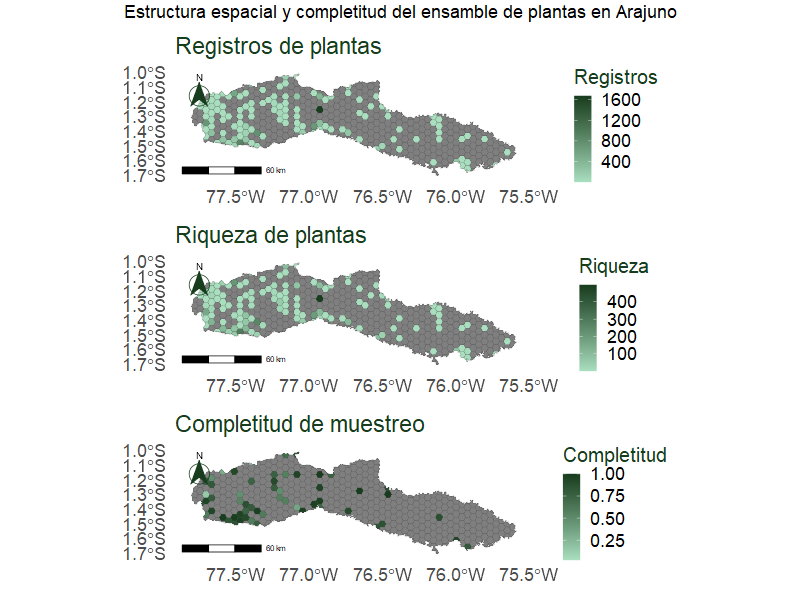

In [501]:
#-----------------------------------------
# Datos base para mapas (registros y spp)
#-----------------------------------------
taxa_filter_records_per_grid <- results_taxa_total %>%
  filter(Group == "Plants")

plants_grid <- grid_10km_cut %>%
  left_join(taxa_filter_records_per_grid, by = "id_10km")


# Mapa: registros
map_plants_records <- make_hex_map(
  data_sf   = plants_grid,
  fill_var  = "Total_records",
  fill_name = "Registros",
  title     = "Registros de plantas"
)

# Mapa: riqueza
map_plants_sp <- make_hex_map(
  data_sf   = plants_grid,
  fill_var  = "Total_sp",
  fill_name = "Riqueza",
  title     = "Riqueza de plantas"
)

# Mapa: completitud (usa hex_birds directamente)
map_plants_sc <- make_hex_map(
  data_sf   = hex_plants,
  fill_var  = "Sampling_coverage",
  fill_name = "Completitud",
  title     = "Completitud de muestreo"
)

maps_grid_plants <- (map_plants_records /
  map_plants_sp /
    map_plants_sc) +
plot_annotation(
title = "Estructura espacial y completitud del ensamble de plantas en Arajuno",
theme = theme(
plot.title = element_text(
hjust = 0.5,
size  = 18,
face  = "plain"
)
)
)

maps_grid_plants

In [502]:
ggsave(
  filename = "../Results/Reports/Plants/mapas_plantas.png",
  plot     = maps_grid_plants,
  width    = 14,
  height   = 18,
  dpi      = 300
)

## 6.2. Grid

### 6.2.1 Sample coverage

Calculamos la completitud de la muestra usando el paquete iNEXT. Para esto se usarán las incidencias de las especies, y dentro de cada grid de 10 km, cada celda de 2 km es una unidad, en done evaluamos como el incluir unidades cambia la cobertura de la muestra

In [470]:
recors_grid_2km

Simple feature collection with 106818 features and 19 fields
Geometry type: POINT
Dimension:     XY
Bounding box:  xmin: -81.2837 ymin: -5.911452 xmax: -74.38333 ymax: 2.00376
Geodetic CRS:  WGS 84
First 10 features:
   id_record database_name database_id                         occurrenceID
1          1          BNDB    BNDB_971 67bd219f-d2d7-4a41-8d4f-ca6a1c12d08b
2          3          BNDB    BNDB_973 b80a793e-c04b-4b41-88db-d8b4dba78506
3          5          BNDB    BNDB_975 c59d8984-031e-4e9c-bf23-a8df7c08661c
4          7          BNDB    BNDB_977 097f5ff4-866e-4e1b-b17e-dd3847addc34
5          9          BNDB    BNDB_979 e7f27209-8604-44de-b43e-4fe8abc2f67c
6         11          BNDB    BNDB_982 8b392663-4188-4e7b-b521-0980ea4d4403
7         13          BNDB    BNDB_985 b7f21191-056b-4024-a0d5-f678dfb20773
8         15          BNDB    BNDB_988 14c6e35a-b276-4320-aedf-3cf0cd79b875
9         17          BNDB    BNDB_990 090cfbfa-0c2f-4462-b1d4-1947399a3946
10        19          B

In [471]:

# Unique 10-km IDs
cid_10km <- unique(recors_grid_2km$id_10km)

# Results container
results_s_cov <- data.frame(
  id_10km = integer(),
  Samplig_coverage = numeric(),  # observed SC
  n_units = numeric(),           # T
  n_incidences = numeric(),      # U
  genus_obs = numeric(),            # S.obs
  Q1 = numeric(),
  Q2 = numeric(),
  sc_ext = numeric(),            # SC at max coverage row
  n_units_ext = numeric(),       # t at max coverage row
  genus_ext = numeric(),            # qD at max coverage row
  stringsAsFactors = FALSE
)

# Progress bar
pb <- txtProgressBar(min = 0, max = length(cid_10km), style = 3)
count <- 0

for (i in cid_10km) {

  # Build incidence matrix (rows = id_2km, cols = species, 0/1)
  records_by_id <- recors_grid_2km %>% dplyr::filter(id_10km == i)

  incidens_matrix_2km <- records_by_id %>%
    as.data.frame() %>%
    dplyr::distinct(id_2km, genus) %>%
    dplyr::mutate(val = 1L) %>%
    tidyr::pivot_wider(names_from = genus, values_from = val, values_fill = 0) %>%
    dplyr::arrange(id_2km)

  ids_unidades_2km <- incidens_matrix_2km$id_2km
  incidens_matrix_2km_df <- incidens_matrix_2km %>% dplyr::select(-id_2km)

  # Ensure numeric 0/1 for iNEXT
  incidens_matrix_2km_df[] <- lapply(incidens_matrix_2km_df, as.numeric)

  # iNEXT input
  inext_grid_2km <- list(ensamblaje = as.data.frame(t(incidens_matrix_2km_df)))

  # Run iNEXT and extract metrics
  sampl_result <- tryCatch({
    result_inext_2km_grid <- iNEXT(
      inext_grid_2km,
      q = 0,
      datatype = "incidence_raw",
      se = FALSE
    )

    sc_obs      <- result_inext_2km_grid$DataInfo$SC
    n_units_obs <- result_inext_2km_grid$DataInfo$T
    n_incid     <- result_inext_2km_grid$DataInfo$U
    genus_obs      <- result_inext_2km_grid$DataInfo$S.obs
    Q1          <- result_inext_2km_grid$DataInfo$Q1
    Q2          <- result_inext_2km_grid$DataInfo$Q2

    cb <- result_inext_2km_grid$iNextEst$coverage_based
    sc_ext      <- if (!is.null(cb)) tail(cb$SC, 1) else NA_real_
    n_units_ext <- if (!is.null(cb)) tail(cb$t,  1) else NA_real_
    genus_ext      <- if (!is.null(cb)) tail(cb$qD, 1) else NA_real_

    data.frame(
      Samplig_coverage = sc_obs,
      n_units = n_units_obs,
      n_incidences = n_incid,
      genus_obs = genus_obs,
      Q1 = Q1,
      Q2 = Q2,
      sc_ext = sc_ext,
      n_units_ext = n_units_ext,
      genus_ext = round(genus_ext, 0),
      stringsAsFactors = FALSE
    )
  }, error = function(e) {
    data.frame(
      Samplig_coverage = NA_real_,
      n_units = NA_real_,
      n_incidences = NA_real_,
      genus_obs = NA_real_,
      Q1 = NA_real_,
      Q2 = NA_real_,
      sc_ext = NA_real_,
      n_units_ext = NA_real_,
      genus_ext = NA_real_,
      stringsAsFactors = FALSE
    )
  })

  # Append row for this 10-km cell
  results_s_cov <- rbind(
    results_s_cov,
    cbind(data.frame(id_10km = i, stringsAsFactors = FALSE), sampl_result)
  )

  count <- count + 1
  setTxtProgressBar(pb, count)
}

# Close progress bar
close(pb)



  |======================================================================| 100%

There were 50 or more warnings (use warnings() to see the first 50)


In [472]:
results_s_cov

    id_10km Samplig_coverage n_units n_incidences genus_obs  Q1 Q2     sc_ext
1      2149           0.1948       4           27        25  23  2 0.35731935
2      4633           0.5017       4           58        45  34  9 0.73989689
3      4444           0.0692       8           33        32  31  1 0.13505533
4      4073           0.0741       2           26        26  26  0 0.21319265
5      4448           0.1705       6           14        13  12  1 0.31865019
6      5089           0.1756       4           15        14  13  1 0.32507449
7      2417           0.1526      11           72        67  62  5 0.28932200
8      3888           0.0599       6           40        39  38  1 0.11714331
9      3143           0.8333       5           48        28  12 12 0.97805213
10     3157           0.0370       5           14        14  14  0 0.20263439
11     2238           0.5342       5           51        39  28 10 0.79514225
12     2807               NA      NA           NA        NA  NA 

In [473]:
View(results_s_cov)

# 7. Exportar resultados

In [484]:

 st_write(grid_10km_samping, "Results/shp/grid_10km_samping_filter.shp", append=FALSE)

Deleting layer `grid_10km_samping_filter' using driver `ESRI Shapefile'
Writing layer `grid_10km_samping_filter' to data source 
  `Results/shp/grid_10km_samping_filter.shp' using driver `ESRI Shapefile'
Writing 7268 features with 24 fields and geometry type Polygon.


Warning message:
In abbreviate_shapefile_names(obj) :
  Field names abbreviated for ESRI Shapefile driver


In [ ]:
plot_units_coverage <- ggiNEXT(res_birds, type = 2) +
  scale_color_manual(values = color_hoja) +
  scale_fill_manual(values = adjustcolor(color_hoja, alpha.f = 0.35)) +
  labs(title = "Hexágonos vs Cobertura de la muestra") +
  custom_theme_fp


plot_units_richness <- ggiNEXT(res_birds, type = 1) +
  scale_color_manual(values = color_hoja) +
  scale_fill_manual(values = adjustcolor(color_hoja, alpha.f = 0.35)) +
  labs(title = "Hexágonos vs Riqueza de especies") +
  custom_theme_fp


grid_10km_cut %>% 
  select(-Total_records) %>% 
  left_join(taxa_filter_records_per_grid, by = "id_10km") %>% 
  ggplot() +
    geom_sf(aes(fill = Total_sp), color = "grey30", size = 0.10) +
    scale_fill_gradient(
      name = "Riqueza de\nespecies",
      low = color_hoja_light,
      high = color_hoja
    ) +
    labs(title = "Riqueza de especies de plantas por celda 10 km") +
      custom_theme_fp_map